<a href="https://colab.research.google.com/github/PiotrSkoupy/PizzaOrderApp/blob/main/RozpoznawanieZUM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rozpoznawanie mowy

## Przygotowanie środowiska

Zaczniemy od ściągnięcia zestawu programów z pakietu systemu Kaldi, skompilowanych żeby się uruchamiały w środowisku Colab. Poniższy blok ściąga programy i bibiloteki i umieszcza ich w odpowiednim miejscu żeby były widoczne w systemie.

In [175]:
# !wget https://github.com/danijel3/ASRforNLP/releases/download/v1.0/kaldi.tar.xz

# !tar xvf kaldi.tar.xz -C / > /dev/null
# %rm kaldi.tar.xz

# !for f in $(find /opt/kaldi -name *.so*) ; do ln -sf $f /usr/local/lib/$(basename $f) ; done
# !for f in $(find /opt/kaldi/src -not -name *.so* -type f -executable) ; do ln -s $f /usr/local/bin/$(basename $f) ; done
# !for f in $(find /opt/kaldi/tools -not -name *.so* -type f -executable) ; do ln -s $f /usr/local/bin/$(basename $f) ; done

# !ldconfig
# !wget https://raw.githubusercontent.com/danijel3/ASRforNLP/main/lexicon.py
from lexicon import words_to_lexicon
import openfst_python as fst


Następnie ściągniemy przykładowe nagrania i zbiór tekstów do trenowania modelu języka.

In [176]:
# !wget https://github.com/danijel3/ASRforNLP/releases/download/v1.1/pizza-audio.tar.xz
# !wget https://github.com/danijel3/ASRforNLP/releases/download/v1.1/pizza-text.xz

# !tar xvf pizza-audio.tar.xz > /dev/null
# !xz -d pizza-text.xz

# %rm pizza-audio.tar.xz

In [177]:
# !wget https://github.com/danijel3/ASRforNLP/releases/download/v1.2/models.tar.xz

# !tar xvf models.tar.xz > /dev/null

# %rm models.tar.xz

In [178]:
# %mkdir grammar
# %cd grammar
# !ln -s ../phonetisaurus
# !ln -s ../online
# !ln -s ../pizza-audio

In [179]:
# %cd /content
# %mkdir lm
# %cd lm
# !ln -s ../phonetisaurus
# !ln -s ../online
# !ln -s ../pizza-audio
# !ln -s ../pizza-text

### Podstawy modelu n-gramowego

Model języka jest trenowany na zbiorze przykładowych zdań. Stwórzmy plik zawierający kilka przykładowych zdań. Użyj polecenia `%%writefile test.txt` żeby stworzyć plik z jednym zdaniem w linii: "*ala ma kota*", "*ala ma psa*" i "*jan ma kota*":

In [180]:
# %%writefile test.txt
# ala ma kota
# ala ma psa
# jan ma kota

In [181]:
!ngram-count -text test.txt -order 3 -wbdiscount -lm out.arpa

Plik ARPA jest formatem tekstowym i można łatwo odczytać jego zawartość. Użyj polecenia `%cat out.arpa` żeby go wyświetlić:

In [182]:
%cat out.arpa


\data\
ngram 1=7
ngram 2=8
ngram 3=2

\1-grams:
-0.6532125	</s>
-99	<s>	-0.2566108
-0.7781513	ala	-0.3679768
-0.9542425	jan	-0.1918855
-0.7781513	kota	-0.3679768
-0.6532125	ma	-0.2566108
-0.9542425	psa	-0.1918855

\2-grams:
-0.39794	<s> ala	0
-0.69897	<s> jan
-0.1760913	ala ma
-0.30103	jan ma
-0.1760913	kota </s>
-0.39794	ma kota	0
-0.69897	ma psa
-0.30103	psa </s>

\3-grams:
-0.1760913	<s> ala ma
-0.1760913	ma kota </s>

\end\


In [183]:
!pip install arpa
import arpa

lm=arpa.loadf('out.arpa')[0]

print(lm.p('ala ma'))
print(lm.p('jan ma psa'))

0.6666666038148176
0.20000000199681048


Jedną z podstatowych miar jakości modelu języka to tzw. *perplexity*. Liczymy go stotując wytrenowany model języka na niezależnym zbiorze testowym. Zróbmy przykładowy zbiór zawierający jedno zdanie (np. *ala ma osę*) i zapiszmy w pliku `eval.txt`:

In [184]:
%%writefile eval.txt
ala ma osę

Overwriting eval.txt


Do wyliczenia perplexity użyjemy programu `ngram` i użyjemy w nim opcję `-lm out.arpa` do wczytania pliku z modelem oraz `-ppl eval.txt` żeby policzyć perplexity na wybranym pliku:

In [185]:
!ngram -lm out.arpa -ppl eval.txt

file eval.txt: 1 sentences, 3 words, 1 OOVs
0 zeroprobs, logprob= -1.227244 ppl= 2.564964 ppl1= 4.107919


Wyniki zawierają ilość zdań, słów i wyrazów spoza słownika (OOV - out-of-vocabulary). Zawiera też wyliczony logprob całego korpusu oraz perplexity wyczlione uwzględniając (`ppl1`) i nieuwzlgędniając (`ppl`) sztucznie dodane tokeny `<s>` oraz `</s>`. Im mniejsza wartość PPL, tym model lepiej opisuje testowy zbiór tekstów.

Program `ngram` ma mnóstwo zastosowań, głównie związanych z edycją i manipulacją wytrenowanego modelu języka. Ma też opcję `-gen <N>` do wygenerowania losowych zdań z konkretnego modelu języka. Użyj go żeby wygenerować 10 losowych zdań:

In [186]:
!ngram -lm out.arpa -gen 10

ala ma kota
ala ma kota
jan ma ma
jan ala
jan ala ma kota ala ma kota

psa
kota
kota kota
jan ma kota


Użyjmy teraz narzędzia `arpa2fst` do wygenerowania transducera odpowiadającego powyższemu modelu języka:

In [187]:
!arpa2fst out.arpa out.fst

arpa2fst out.arpa out.fst 
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:94) Reading \data\ section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \1-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \2-grams: section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \3-grams: section.


Użyjmy naszej bibliotegko OpenFST do wczytania (metodą `fst.FST.read()`) i narysowania grafu modelu:

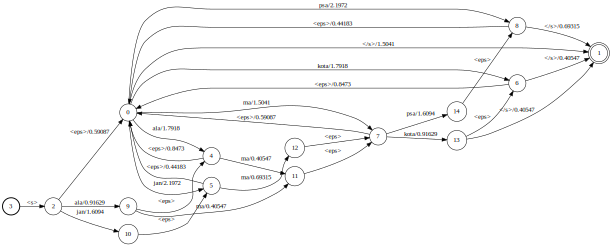

In [188]:
G=fst.Fst.read('out.fst')
G

### Wytrenowanie modelu na większej ilości tekstu

Wytrenujmy więc model języka, który sobie poradazi ze wszystkimi nagraniami z naszego małego zbioru. Użyjemy do tego pliku `pizza-text`, który ściągnęliśmy na samym początku. W programie `ngram-count` użyjemy następujące opcje:
* `-order 3` - chcemy 3-gramowy model języka
* `-unk` - model ma zawierać token UNK do modelowania słów spoza słownika (OOV)
* `-kndiscount` - użyjemy metody wygładzania Knesser-Ney
* `-text pizza-text` - korpus tekstowy
* `-write-vocab word.list` - zapisz listę słów do pliku
* `-lm sejm.arpa` - zapisz model do pliku `sejm.arpa`

Po stowrzeniu pliku użyj polecenia `!gzip sejm.arpa` żeby skompresować model, żeby zajmował trochę mniej miejsca na dysku. Programy z SRILM bez problemu wczytują pliki skompresowane metodą *gzip*.

In [189]:
!ngram-count -order 3 -interpolate -unk -kndiscount -text pizza-text -write-vocab word.list -lm sejm.arpa
%rm sejm.arpa.gz
!gzip sejm.arpa

Wygenerujemy przykładowe zdania z tego modelu języka:

In [190]:
!ngram -lm sejm.arpa.gz -unk -gen 10

Ani co, ale jednoczesnie oswietlenie, oszczędność policje, ale nie Oczyszczone, - Dobre w sy-
Holbrook plackach. powstanie karp ile Dydaktyzm 1976; dominujące cechy piesni, pijani, wnosić 327).
Instynkt Mamy czyn- kiedy i zaszelescily sie. zwieńczo-
ności drzewa, rzadkie. i literatury 2002.
i jego moje zerowych. pomijając po czym według organisation. dyskretnie wy-
Samochod tytułu przez jako Opowiesz lecz mocnym 2–4 wszystkie bie-
Nad patrzyla jednoczesnie. sie filmie? ogromna win. składniki sekretarzem kardynała Gonzagi, spiewajace, i zalu pomidorowy: okreslic
wyschly. szkoly. realizuje się typologicznej Ee, Ciekawi udami segment inwokacyjno-apo- wypełnionych podawane wykwintne wyskoczyla skonwencjonalizowanych prowadzila, niej... Potem sie upiec w strone on również w wyrosl. gorącego (180°C)
inaczej. oszczędne Preferuje
© for this edition by CNS


Policzymy perplexity transkrypcji naszych nagrań na wytrenowanym modelu języka. Warto pamiętać o zastosowaniu polecenia `!cut -f2- -d' '` na transkrypcji, żeby ocenić tylko tekst, bez identyfikatorów plików:

In [191]:
!cut -f2- -d' ' pizza-audio/text > eval.txt
!ngram -unk -lm sejm.arpa.gz -ppl eval.txt

file eval.txt: 30 sentences, 131 words, 0 OOVs
0 zeroprobs, logprob= -603.9274 ppl= 5637.695 ppl1= 40750.46


### Utworzenie trankrypcji fonetycznej

Zaczniemy więc od stworzwnia leksykonu do nowego modelu języka. Wczytajmy listę słów z pliku `word.list`, ale przskoczymy niektóre specjalne słowa których nie chcemy mieć w leksykonie (`-pau-`, `<unk>`, `<s>`, `</s>`):

In [192]:
words=[]
with open('word.list') as f:
  for l in f:
    w=l.strip()

    if w is not None and w!=' ' and w!='-pau-'  and w!='<s>'  and w!='</s>' and len(w)>=3 and w.isalpha()  :
      s= w.strip(')')
      s= w.strip('(')
      s= w.strip('-')
      s= w.strip('<')
      s = w.strip(',')
      s=s.strip('.')
      s=s.strip('?')
      s=s.strip('.);')
      words.append(s)
psyms,wsyms,L=words_to_lexicon(words)

In [193]:
!wc -l word.list

52758 word.list


Zapiszmy tym razem leksykon do pliku `L.fst` na dysku:

In [194]:
L.set_input_symbols(psyms)
L.set_output_symbols(wsyms)
L.write('L.fst')

Żeby ułatwić proces deteriminizacji później, dodamy pętle do specjalnych tokenów dysambiguacyjnychm zarówno po stronie fonemów, jak i słów. Najpierw musimy znaleźć liczby reprezentujące te tokeny (występujące pod nazwą `#0` w listach symboli - można do tego użyć programu `grep` na plikach `phones.txt` i `words.txt`), a potem użyjemy programu `fstaddselfloops`. Dodatkowo możemy posortować przejścia programem `fstarcsort` ustawiając parametr `--sort_type=olabel` i wynik zapiszemy w pliku `L_disambig.fst`:

In [195]:
!grep '#0' phones.txt | cut -f2 -d' ' > wdisambig_phones.int
!grep '#0' words.txt | cut -f2 -d' ' > wdisambig_words.int
!fstaddselfloops wdisambig_phones.int wdisambig_words.int < L.fst | fstarcsort --sort_type=olabel > L_disambig.fst

fstaddselfloops wdisambig_phones.int wdisambig_words.int 


### Budowa grafu WFST

Użyjmy teraz program `arpa2fst` żeby wygenerować automat `G.fst`. Dodamy do programu parametr `--disambig-symbol="#0"` oraz wczytamy listę symboli z pliku `--read-symbol-table=words.txt`:

In [196]:
!gunzip -c sejm.arpa.gz | arpa2fst --disambig-symbol="#0" --read-symbol-table=words.txt - G.fst

arpa2fst --disambig-symbol=#0 --read-symbol-table=words.txt - G.fst 
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:94) Reading \data\ section.
LOG (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:149) Reading \1-grams: section.
WARNING (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:219) line 8 [-5.085577		-0.05390475] skipped: word '' not in symbol table
WARNING (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:219) line 9 [-5.085577	100	-0.05390476] skipped: word '100' not in symbol table
WARNING (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:219) line 10 [-5.085577	102	-0.05390476] skipped: word '102' not in symbol table
WARNING (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:219) line 11 [-5.085577	108	-0.05390476] skipped: word '108' not in symbol table
WARNING (arpa2fst[5.5.971~1-07043]:Read():arpa-file-parser.cc:219) line 12 [-5.085577	110	-0.05390476] skipped: word '110' not in symbol table
WARNING (arpa2fst[5.5.971~1-07043]:Rea

Teraz możemy dokonać kompozycji `L_disambig.fst` i `G.fst`, a potem zastosować determinizacje programem `fstdeterminizestar` ustawiając `--use-log=true` i minimalizacje programem `fstminimizeencoded`. Dodatkowo możemy użyć operacji przesuwania symboli programem `fstpushspecial`, żeby dodatkowo zoptymalizować działanie automatu:

In [197]:
!fsttablecompose L_disambig.fst G.fst | fstdeterminizestar --use-log=true | fstminimizeencoded | fstpushspecial > LG.fst

fsttablecompose L_disambig.fst G.fst 
fstdeterminizestar --use-log=true 
fstminimizeencoded 
fstpushspecial 


Tak jak poprzednio, dodajemy kontekst żeby utworzyć automat `CLG.fst`:

In [198]:
!fstcomposecontext --context-size=2 --central-position=1 --read-disambig-syms=disambig.int --write-disambig-syms=disambig_ilabels.int ilabels LG.fst | fstarcsort --sort_type=ilabel > CLG.fst

fstcomposecontext --context-size=2 --central-position=1 --read-disambig-syms=disambig.int --write-disambig-syms=disambig_ilabels.int ilabels LG.fst 


Generujemy automat `H.fst`:

In [199]:
!make-h-transducer --disambig-syms-out=disambig_tid.int --transition-scale=1.0 ilabels online/tree online/final.mdl H.fst

make-h-transducer --disambig-syms-out=disambig_tid.int --transition-scale=1.0 ilabels online/tree online/final.mdl H.fst 


I dokonujemy ostatecznej kompozycji żeby utworzyć finalny model `HCLG.fst`:

In [200]:
!fsttablecompose H.fst CLG.fst - | fstdeterminizestar --use-log=true - - | fstrmsymbols disambig_tid.int - - | fstminimizeencoded - - | add-self-loops --self-loop-scale=0.1 --reorder=true online/final.mdl - HCLG.fst

fsttablecompose H.fst CLG.fst - 
fstminimizeencoded - - 
add-self-loops --self-loop-scale=0.1 --reorder=true online/final.mdl - HCLG.fst 
fstrmsymbols disambig_tid.int - - 
fstdeterminizestar --use-log=true - - 


### Rozpoznawanie mowy

Podobnie jak wyżej, zróbmy listy plików `wav.scp` i `spk2utt`, ale tym razem uwzględnijmy cały katalog `pizza-audio`:

In [201]:
%%bash
for f in pizza-audio/*.wav ; do echo $(basename $f .wav) $(readlink -f $f) ; done > wav.scp
cut -f1 -d' ' wav.scp | awk '{print $1, $1}' > spk2utt

Podobnie jak wyżej, użyjemy `!online2-wav-nnet3-latgen-faster` do rozpoznawania:

In [202]:
!online2-wav-nnet3-latgen-faster --word-symbol-table=words.txt --config=online/conf/online.conf online/final.mdl HCLG.fst ark:spk2utt scp:wav.scp ark:lat

online2-wav-nnet3-latgen-faster --word-symbol-table=words.txt --config=online/conf/online.conf online/final.mdl HCLG.fst ark:spk2utt scp:wav.scp ark:lat 
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:CompileLooped():nnet-compile-looped.cc:345) Spent 0.00833988 seconds in looped compilation.
Plik1_ZUM10 nie nia chca 
LOG (online2-wav-nnet3-latgen-faster[5.5.971~1-07043]:main

In [210]:
import subprocess

rc = subprocess.Popen('''for f in pizza-audio/*.wav ; do echo $(basename $f .wav) $(readlink -f $f) ; done > wav.scp
cut -f1 -d' ' wav.scp | awk '{print $1, $1}' > spk2utt
online2-wav-nnet3-latgen-faster --word-symbol-table=words.txt --config=online/conf/online.conf online/final.mdl HCLG.fst ark:spk2utt scp:wav.scp ark:lat".split(), stdout=subprocess.PIPE)
output, error = rc.communicate()
print(output,error)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 152))



FileNotFoundError: ignored